<a href="https://colab.research.google.com/github/sapoirier9/ores5160-2025/blob/main/Poirier%2C_S_ORES_5160_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
from google.colab import files
uploaded = files.upload()

Saving county_natality_by_abnormal_conditions.json to county_natality_by_abnormal_conditions (9).json
Saving hpsa_primary_care.csv to hpsa_primary_care (8).csv


In [114]:
import pandas as pd

In [115]:
import numpy as np

In [139]:
import logging

logging.basicConfig(
    filename='data_pipeline.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

console = logging.StreamHandler()
console.setLevel(logging.INFO)
logging.getLogger('').addHandler(console)

def load_json_with_logging(filepath):
    """Load JSON file with error handling and logging"""
    try:
        df = pd.read_json(filepath)
        logging.info(f"✓ Successfully loaded {filepath}")
        logging.info(f"  - Rows: {len(df)}, Columns: {len(df.columns)}")
        return df
    except FileNotFoundError:
        logging.error(f"✗ File not found: {filepath}")
        raise
    except ValueError as e:
        logging.error(f"✗ Invalid JSON format: {str(e)}")
        raise

def load_csv_with_logging(filepath):
    """Load CSV file with error handling and logging"""
    try:
        df = pd.read_csv(filepath)
        logging.info(f"✓ Successfully loaded {filepath}")
        logging.info(f"  - Rows: {len(df)}, Columns: {len(df.columns)}")
        return df
    except FileNotFoundError:
        logging.error(f"✗ File not found: {filepath}")
        raise

def clean_missing_values(df, dataset_name):
    """Clean missing values with logging"""
    try:
        initial_rows = len(df)

        missing_summary = df.isnull().sum()
        missing_cols = missing_summary[missing_summary > 0]

        if len(missing_cols) > 0:
            logging.info(f"\n{dataset_name} - Missing values before cleaning:")
            for col, count in missing_cols.items():
                pct = (count / initial_rows) * 100
                logging.info(f"  - {col}: {count} ({pct:.2f}%)")

        df.replace(['',' ','NA','N/A'], np.nan, inplace=True)
        df.dropna(inplace=True)

        rows_removed = initial_rows - len(df)
        pct_removed = (rows_removed / initial_rows) * 100

        logging.info(f"\n{dataset_name} - Cleaning complete:")
        logging.info(f"  - Rows removed: {rows_removed} ({pct_removed:.2f}%)")
        logging.info(f"  - Remaining rows: {len(df)}")

        return df
    except Exception as e:
        logging.error(f"✗ Error cleaning {dataset_name}: {str(e)}")
        raise

def drop_columns_with_logging(df, columns_to_drop, dataset_name):
    """Drop columns with error handling and logging"""
    try:
        existing_cols = [col for col in columns_to_drop if col in df.columns]
        missing_cols = [col for col in columns_to_drop if col not in df.columns]

        if missing_cols:
            logging.warning(f"\n{dataset_name} - Columns not found: {missing_cols}")

        if existing_cols:
            df = df.drop(existing_cols, axis=1)
            logging.info(f"\n{dataset_name} - Dropped {len(existing_cols)} columns")
            logging.info(f"  - Remaining columns: {len(df.columns)}")

        return df
    except Exception as e:
        logging.error(f"✗ Error dropping columns: {str(e)}")
        raise

In [140]:
def convert_data_types_simple(df, columns_to_convert, dataset_name):
    """Convert columns to numeric/datetime with error handling"""
    try:
        logging.info(f"\n{dataset_name} - Converting data types:")

        for col in columns_to_convert:
            if col in df.columns:
                if 'date' in col.lower() or 'year' in col.lower():
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                    logging.info(f"  ✓ {col} → datetime")
                else:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    logging.info(f"  ✓ {col} → numeric")

        return df
    except Exception as e:
        logging.error(f"✗ Error: {str(e)}")
        raise

In [118]:
try:
    abconditions = load_json_with_logging('county_natality_by_abnormal_conditions.json')
    primarycare = load_csv_with_logging('hpsa_primary_care.csv')
except Exception as e:
    print(f"CRITICAL ERROR: Could not load files - {e}")
    raise

In [119]:
abconditions.head()

,Year,County_of_Residence,County_of_Residence_FIPS,Abnormal_Conditions_Checked_Desc,Abnormal_Conditions_Checked_YN,Births,Ave_Age_of_Mother,Ave_OE_Gestational_Age_Wks,Ave_LMP_Gestational_Age_Wks,Ave_Birth_Weight_gms,Ave_Pre_pregnancy_BMI,Ave_Number_of_Prenatal_Wks
0,1/1/2017,"Shelby County, AL",1117,None checked,1,2067,29.44,38.75,38.72,3353.80,26.82,10.85
1,1/1/2017,"Gwinnett County, GA",13135,None checked,1,10199,29.77,38.75,38.75,3301.87,26.54,11.49
2,1/1/2017,"San Francisco County, CA",6075,None checked,1,8000,32.97,39.00,39.08,3323.30,23.96,11.27
3,1/1/2017,"Oswego County, NY",36075,None checked,1,1087,27.44,39.00,39.24,3377.58,28.94,12.90
4,1/1/2017,"Deschutes County, OR",41017,None checked,1,1639,29.81,39.25,39.22,3378.41,25.55,10.96


In [120]:
primarycare.head()

,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,Address,City,State_Abbr,Postal_Code,...,Common_State_Name,Common_State_FIPS,Common_Region_Name,HPSA_Withdrawn_Date,HPSA_Withdrawn_Date_String,Provider_Type,Rural_Status_Code,Rural_Status_Desc,HPSA_Designation_Pop_Type_Desc,BHCMIS_OrgID
0,1569995651,Ft. Washakie PHS Indian Health Center,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",PO BOX 128,Fort Washakie,WY,82514-0128,...,Wyoming,56,Region VIII,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN
1,1469994698,McLaughlin PHS Indian Medical/Dental Clinic,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",611 2nd Ave E,Mc Laughlin,SD,57642,...,South Dakota,46,Region VIII,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN
2,1469994687,Wagner PHS Indian Hospital,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",110 Washington Ave NW,Wagner,SD,57380,...,South Dakota,46,Region VIII,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN
3,141999413V,Portland Area Office,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",1220 SW 3rd Ave Ste 476,Portland,OR,97204-2825,...,Oregon,41,Region X,NaN,NaN,NaN,N,Non-Rural,"Indian, Tribal and Urban Indian Organizations",NaN
4,14099940N2,Shawnee Health Center,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",2307 Gordon Cooper Dr,Shawnee,OK,74801-9007,...,Oklahoma,40,Region VI,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN


In [121]:
abconditions.info()
abconditions.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              500 non-null    object 
 1   County_of_Residence               500 non-null    object 
 2   County_of_Residence_FIPS          500 non-null    int64  
 3   Abnormal_Conditions_Checked_Desc  500 non-null    object 
 4   Abnormal_Conditions_Checked_YN    500 non-null    int64  
 5   Births                            500 non-null    int64  
 6   Ave_Age_of_Mother                 500 non-null    float64
 7   Ave_OE_Gestational_Age_Wks        500 non-null    float64
 8   Ave_LMP_Gestational_Age_Wks       500 non-null    float64
 9   Ave_Birth_Weight_gms              500 non-null    float64
 10  Ave_Pre_pregnancy_BMI             500 non-null    float64
 11  Ave_Number_of_Prenatal_Wks        500 non-null    float64
dtypes: float

,Year,County_of_Residence,County_of_Residence_FIPS,Abnormal_Conditions_Checked_Desc,Abnormal_Conditions_Checked_YN,Births,Ave_Age_of_Mother,Ave_OE_Gestational_Age_Wks,Ave_LMP_Gestational_Age_Wks,Ave_Birth_Weight_gms,Ave_Pre_pregnancy_BMI,Ave_Number_of_Prenatal_Wks
count,500,500,500.000000,500,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
unique,1,500,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1/1/2017,"Cambria County, PA",NaN,None checked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,500,1,NaN,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,29615.866000,NaN,1.0,5667.464000,28.566220,38.786100,38.928880,3341.127960,27.104040,11.520320
std,NaN,NaN,15482.326545,NaN,0.0,8792.742129,1.298225,0.188868,0.248524,59.454273,0.859839,0.947259
min,NaN,NaN,1003.000000,NaN,1.0,674.000000,26.040000,38.200000,35.800000,3158.100000,23.790000,9.030000
25%,NaN,NaN,17097.000000,NaN,1.0,1559.250000,27.655000,38.670000,38.810000,3304.740000,26.597500,10.860000
50%,NaN,NaN,31027.000000,NaN,1.0,2670.500000,28.390000,38.780000,38.960000,3343.835000,27.150000,11.490000
75%,NaN,NaN,42049.500000,NaN,1.0,5808.250000,29.372500,38.920000,39.070000,3385.780000,27.720000,12.082500


In [122]:
try:
    abconditions = clean_missing_values(abconditions, 'Abnormal Conditions')
except Exception as e:
    print(f"ERROR during cleaning: {e}")
    raise

In [123]:
abconditions.head()

,Year,County_of_Residence,County_of_Residence_FIPS,Abnormal_Conditions_Checked_Desc,Abnormal_Conditions_Checked_YN,Births,Ave_Age_of_Mother,Ave_OE_Gestational_Age_Wks,Ave_LMP_Gestational_Age_Wks,Ave_Birth_Weight_gms,Ave_Pre_pregnancy_BMI,Ave_Number_of_Prenatal_Wks
0,1/1/2017,"Shelby County, AL",1117,None checked,1,2067,29.44,38.75,38.72,3353.80,26.82,10.85
1,1/1/2017,"Gwinnett County, GA",13135,None checked,1,10199,29.77,38.75,38.75,3301.87,26.54,11.49
2,1/1/2017,"San Francisco County, CA",6075,None checked,1,8000,32.97,39.00,39.08,3323.30,23.96,11.27
3,1/1/2017,"Oswego County, NY",36075,None checked,1,1087,27.44,39.00,39.24,3377.58,28.94,12.90
4,1/1/2017,"Deschutes County, OR",41017,None checked,1,1639,29.81,39.25,39.22,3378.41,25.55,10.96


In [124]:
primarycare.head()

,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,Address,City,State_Abbr,Postal_Code,...,Common_State_Name,Common_State_FIPS,Common_Region_Name,HPSA_Withdrawn_Date,HPSA_Withdrawn_Date_String,Provider_Type,Rural_Status_Code,Rural_Status_Desc,HPSA_Designation_Pop_Type_Desc,BHCMIS_OrgID
0,1569995651,Ft. Washakie PHS Indian Health Center,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",PO BOX 128,Fort Washakie,WY,82514-0128,...,Wyoming,56,Region VIII,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN
1,1469994698,McLaughlin PHS Indian Medical/Dental Clinic,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",611 2nd Ave E,Mc Laughlin,SD,57642,...,South Dakota,46,Region VIII,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN
2,1469994687,Wagner PHS Indian Hospital,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",110 Washington Ave NW,Wagner,SD,57380,...,South Dakota,46,Region VIII,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN
3,141999413V,Portland Area Office,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",1220 SW 3rd Ave Ste 476,Portland,OR,97204-2825,...,Oregon,41,Region X,NaN,NaN,NaN,N,Non-Rural,"Indian, Tribal and Urban Indian Organizations",NaN
4,14099940N2,Shawnee Health Center,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",2307 Gordon Cooper Dr,Shawnee,OK,74801-9007,...,Oklahoma,40,Region VI,NaN,NaN,NaN,R,Rural,"Indian, Tribal and Urban Indian Organizations",NaN


In [125]:
print(primarycare.columns)

Index(['Source_ID', 'Source_Name', 'Status_Code', 'Status_Description',
       'Type_Code', 'Type_Desc', 'Address', 'City', 'State_Abbr',
       'Postal_Code', 'Degree_of_Shortage', 'Designation_Date',
       'Designation_Last_Update_Date', 'Designation_Pop',
       'Estimated_Underserved_Pop', 'Estimated_Served_Pop', 'Formal_Ratio',
       'Total_FTE_Clinicians', 'Metropolitan_Indicator_Code',
       'Metropolitan_Indicator_Desc', 'Provider_Ratio_Goal',
       'Percent_Pop_Below_Poverty', 'HPSA_Score', 'HPSA_Shortage',
       'Discipline_Class_Num', 'Discipline_Class_Desc', 'Component_Source_ID',
       'Component_Source_Name', 'Component_Status_Code',
       'Component_Status_Desc', 'Component_Type_Code', 'Component_Type_Desc',
       'Component_State_Abbr', 'Component_Postal_Code',
       'Component_Designation_Date', 'Component_Designation_Date_String',
       'Component_Designation_Last_Update_Date', 'Geography_ID', 'CountyFIPS',
       'County_Name', 'StateCountyFIPS', 'State_FIP

In [126]:
columns_to_remove = [
    'Degree_of_Shortage','Estimated_Underserved_Pop','Estimated_Served_Pop',
    'Formal_Ratio','Total_FTE_Clinicians','Provider_Ratio_Goal',
    'Percent_Pop_Below_Poverty','Component_State_Abbr','Component_Postal_Code',
    'Component_Designation_Date','Component_Designation_Date_String',
    'Component_Designation_Last_Update_Date','HPSA_Pop_Type_Code',
    'HPSA_Pop_Type_Desc','HPSA_Resident_Civilian_Pop','HPSA_Withdrawn_Date',
    'HPSA_Withdrawn_Date_String','Provider_Type','BHCMIS_OrgID'
]

try:
    primarycare = drop_columns_with_logging(primarycare, columns_to_remove, 'Primary Care')
except Exception as e:
    print(f"ERROR dropping columns: {e}")
    raise

In [127]:
print(primarycare.columns)

Index(['Source_ID', 'Source_Name', 'Status_Code', 'Status_Description',
       'Type_Code', 'Type_Desc', 'Address', 'City', 'State_Abbr',
       'Postal_Code', 'Designation_Date', 'Designation_Last_Update_Date',
       'Designation_Pop', 'Metropolitan_Indicator_Code',
       'Metropolitan_Indicator_Desc', 'HPSA_Score', 'HPSA_Shortage',
       'Discipline_Class_Num', 'Discipline_Class_Desc', 'Component_Source_ID',
       'Component_Source_Name', 'Component_Status_Code',
       'Component_Status_Desc', 'Component_Type_Code', 'Component_Type_Desc',
       'Geography_ID', 'CountyFIPS', 'County_Name', 'StateCountyFIPS',
       'State_FIPS', 'State_Abbr_2', 'State_Name', 'Primary_State_Name',
       'Primary_State_FIPS', 'Primary_HHS_Region_Name',
       'US_Mexico_Border_County', 'US_Mexico_Border_100km',
       'Data_Warehouse_Record_Create_Date',
       'Data_Warehouse_Record_Create_Date_Text', 'HPSA_Name',
       'HPSA_Component_Name', 'Break_in_Designation', 'Geocoding_Primary_X',
     

In [128]:
primarycare.head()

,Source_ID,Source_Name,Status_Code,Status_Description,Type_Code,Type_Desc,Address,City,State_Abbr,Postal_Code,...,Common_Postal_Code,Common_County_Name,Common_StateCounty_FIPS,Common_State_Abbr,Common_State_Name,Common_State_FIPS,Common_Region_Name,Rural_Status_Code,Rural_Status_Desc,HPSA_Designation_Pop_Type_Desc
0,1569995651,Ft. Washakie PHS Indian Health Center,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",PO BOX 128,Fort Washakie,WY,82514-0128,...,82514,"Fremont County, WY",56013,WY,Wyoming,56,Region VIII,R,Rural,"Indian, Tribal and Urban Indian Organizations"
1,1469994698,McLaughlin PHS Indian Medical/Dental Clinic,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",611 2nd Ave E,Mc Laughlin,SD,57642,...,57642,"Corson County, SD",46031,SD,South Dakota,46,Region VIII,R,Rural,"Indian, Tribal and Urban Indian Organizations"
2,1469994687,Wagner PHS Indian Hospital,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",110 Washington Ave NW,Wagner,SD,57380,...,57380,"Charles Mix County, SD",46023,SD,South Dakota,46,Region VIII,R,Rural,"Indian, Tribal and Urban Indian Organizations"
3,141999413V,Portland Area Office,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",1220 SW 3rd Ave Ste 476,Portland,OR,97204-2825,...,97204,"Multnomah County, OR",41051,OR,Oregon,41,Region X,N,Non-Rural,"Indian, Tribal and Urban Indian Organizations"
4,14099940N2,Shawnee Health Center,D,Designated,IHS,"Indian, Tribal and Urban Indian Organizations",2307 Gordon Cooper Dr,Shawnee,OK,74801-9007,...,74801,"Pottawatomie County, OK",40125,OK,Oklahoma,40,Region VI,R,Rural,"Indian, Tribal and Urban Indian Organizations"


In [141]:
try:
    abconditions = convert_data_types_simple(
        abconditions,
        ['Year', 'Births', 'Ave_Age_of_Mother', 'Ave_Birth_Weight_gms', 'Ave_Pre_pregnancy_BMI'],
        'Abnormal Conditions'
    )

    primarycare = convert_data_types_simple(
        primarycare,
        ['Designation_Date', 'HPSA_Score'],
        'Primary Care'
    )

    print("✓ Data types converted")
except Exception as e:
    print(f"ERROR: {e}")
    raise

✓ Data types converted


In [142]:
try:
    validate_data_quality(abconditions, 'Abnormal Conditions')
    validate_data_quality(primarycare, 'Primary Care')
except Exception as e:
    print(f"ERROR: {e}")
    raise

  ⚠ Births: 53 outliers detected
  ⚠ Births: 53 outliers detected
  ⚠ Births: 53 outliers detected
  ⚠ Births: 53 outliers detected
  ⚠ Births: 53 outliers detected
  ⚠ Births: 53 outliers detected
  ⚠ Births: 53 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_Age_of_Mother: 5 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_OE_Gestational_Age_Wks: 4 outliers detected
  ⚠ Ave_LMP_Gestational_Age_Wks: 8 outliers detected
  ⚠ Ave_LMP_Gestational_Age_Wks: 8 outliers detecte

✓ Validation complete for Abnormal Conditions
✓ Validation complete for Primary Care


In [143]:
try:
    logging.info("\nChecking logical constraints:")

    invalid_age = ((abconditions['Ave_Age_of_Mother'] < 15) |
                   (abconditions['Ave_Age_of_Mother'] > 50)).sum()

    if invalid_age > 0:
        logging.warning(f"  ⚠ {invalid_age} unrealistic age values")
    else:
        logging.info(f"  ✓ All ages are realistic (15-50)")

    invalid_weight = ((abconditions['Ave_Birth_Weight_gms'] < 500) |
                      (abconditions['Ave_Birth_Weight_gms'] > 6000)).sum()

    if invalid_weight > 0:
        logging.warning(f"  ⚠ {invalid_weight} unrealistic birth weights")
    else:
        logging.info(f"  ✓ All birth weights are realistic (500-6000g)")

    print("\n" + "="*60)
    print("✓ ALL VALIDATION COMPLETE!")
    print("="*60)
    print("Check 'data_pipeline.log' for detailed logs")

except Exception as e:
    print(f"ERROR: {e}")
    raise


✓ ALL VALIDATION COMPLETE!
Check 'data_pipeline.log' for detailed logs


In [144]:
try:
    primarycare_by_county = primarycare.groupby('StateCountyFIPS').agg({
        'Source_Name': 'count',
        'HPSA_Score': 'mean'
    }).reset_index()

    primarycare_by_county.rename(columns={
        'Source_Name': 'Num_Health_Facilities',
        'HPSA_Score': 'Avg_HPSA_Score'
    }, inplace=True)

    print(f"✓ Aggregated to county level: {len(primarycare_by_county)} counties")
    print(primarycare_by_county.head())

except Exception as e:
    print(f"ERROR: {e}")
    raise

✓ Aggregated to county level: 281 counties
   StateCountyFIPS  Num_Health_Facilities  Avg_HPSA_Score
0             2016                      1             9.0
1             2020                      2             4.0
2             2070                      1             8.0
3             2110                      1            13.0
4             2122                      1             7.0


In [134]:
merged_data = pd.merge(
    abconditions,
    primarycare_by_county,
    left_on='County_of_Residence_FIPS',
    right_on='StateCountyFIPS',
    how='left'
)

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

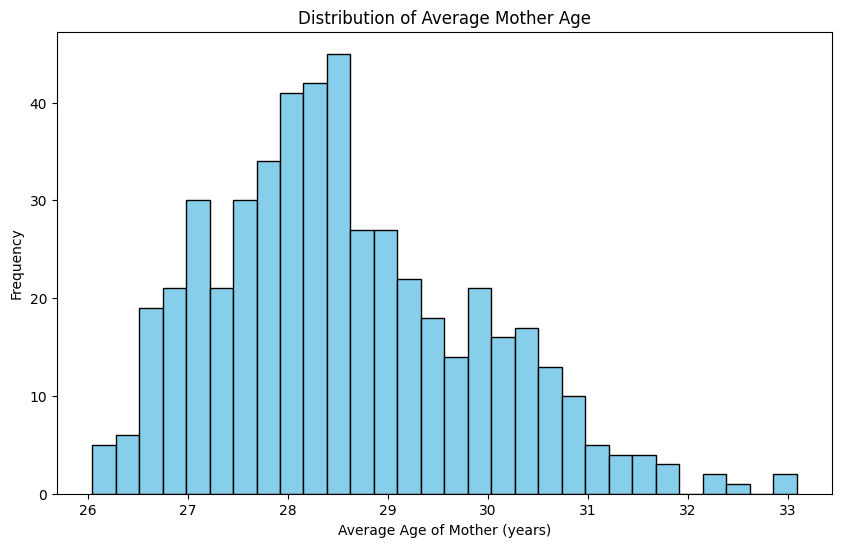

In [137]:
try:
    plt.figure(figsize=(10, 6))
    plt.hist(abconditions['Ave_Age_of_Mother'], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Average Age of Mother (years)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Average Mother Age')
    plt.show()
except Exception as e:
    print(f"ERROR: {e}")

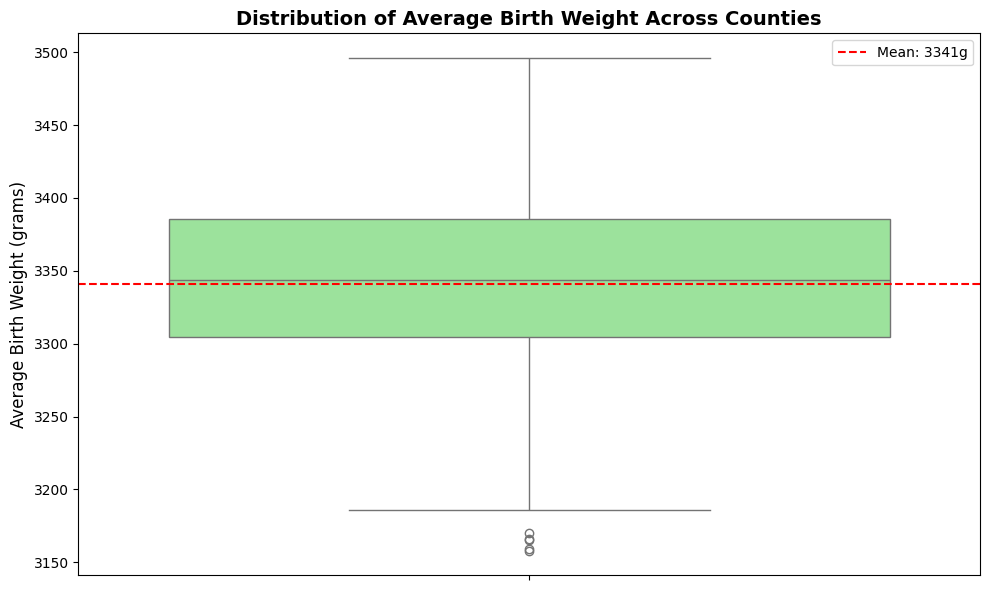

Mean birth weight: 3341 grams
Outliers detected: Any points outside the whiskers


In [138]:
try:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=abconditions['Ave_Birth_Weight_gms'], color='lightgreen')
    plt.ylabel('Average Birth Weight (grams)', fontsize=12)
    plt.title('Distribution of Average Birth Weight Across Counties', fontsize=14, fontweight='bold')
    plt.axhline(abconditions['Ave_Birth_Weight_gms'].mean(), color='red', linestyle='--', label=f'Mean: {abconditions["Ave_Birth_Weight_gms"].mean():.0f}g')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Mean birth weight: {abconditions['Ave_Birth_Weight_gms'].mean():.0f} grams")
    print(f"Outliers detected: Any points outside the whiskers")

except Exception as e:
    print(f"ERROR creating boxplot: {e}")